In [1]:
import numpy as np
import pandas as pd
from datetime import date, timedelta
import os
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import skew, kurtosis

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras import layers,Sequential,losses,optimizers,datasets

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K

def setup_seed(seed):
    random.seed(seed)  # 为python设置随机种子
    np.random.seed(seed)  # 为numpy设置随机种子
    tf.random.set_seed(seed)  # tf cpu fix seed
    os.environ['TF_DETERMINISTIC_OPS'] = '1'  # tf gpu fix seed, please `pip install tensorflow-determinism` first

setup_seed(2020)


seed = 2020
random.seed = 2020
np.random.seed = 2020
tf.seed = 2020
tf.random.set_seed(2020)

In [2]:
import tensorflow as tf

class CorrelationLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(CorrelationLayer, self).__init__()

    def call(self, x):
        # Compute mean and standard deviation for each batch and node
        mean = tf.reduce_mean(x, axis=1, keepdims=True)
        std = tf.math.reduce_std(x, axis=1, keepdims=True)

        # Compute centered inputs
        x_centered = x - mean

        # Compute covariance matrix for each batch and node
        covariance_matrix = tf.matmul(x_centered, x_centered, transpose_b=True)

        # Compute correlation matrix using covariance matrix and standard deviation
        correlation_matrix = tf.divide(covariance_matrix, tf.matmul(std, std, transpose_b=True))

        # Compute Laplacian transformation of correlation matrix
        laplacian_transform = self.localpooling_filter(correlation_matrix)

        return laplacian_transform

    def localpooling_filter(self, matrix):
        # Compute diagonal degree matrix
        degree_matrix = tf.linalg.diag(tf.reduce_sum(matrix, axis=1))

        # Compute graph Laplacian
        laplacian_matrix = degree_matrix - matrix

        # Compute Laplacian eigenvectors and eigenvalues
        eigenvalues, eigenvectors = tf.linalg.eigh(laplacian_matrix)

        # Compute Laplacian Fourier Transform
        laplacian_transform = tf.matmul(eigenvectors, tf.matmul(tf.linalg.diag(eigenvalues), eigenvectors, adjoint_b=True))

        return laplacian_transform



In [3]:
### IMPORT SPEKTRAL CLASSES ###

from spektral_utilities import *
from spektral_gcn import GraphConv

In [4]:
import scipy.io as scio
import pandas as pd

#input Train
feature1tr = r'\训练集\ACC_EW.mat'
data1tr = scio.loadmat(feature1tr)
AAtr=data1tr['ACC_EW']
Atr=AAtr[:,0:300]

feature2tr = r'\训练集\ACC_NS.mat'
data2tr = scio.loadmat(feature2tr)
BBtr=data2tr['ACC_NS']
Btr=BBtr[:,0:300]

feature3tr = r'\训练集\ACC_UD.mat'
data3tr = scio.loadmat(feature3tr)
CCtr=data3tr['ACC_UD']
Ctr=CCtr[:,0:300]

feature4tr = r'\训练集\DIS_EW.mat'
data4tr = scio.loadmat(feature4tr)
DDtr=data4tr['DIS_EW']
Dtr=DDtr[:,0:300]

feature5tr = r'\训练集\DIS_NS.mat'
data5tr = scio.loadmat(feature5tr)
EEtr=data5tr['DIS_NS']
Etr=EEtr[:,0:300]

feature6tr = r'\训练集\DIS_UD.mat'
data6tr = scio.loadmat(feature6tr)
FFtr=data6tr['DIS_UD']
Ftr=FFtr[:,0:300]

feature7tr = r'\训练集\VEL_EW.mat'
data7tr = scio.loadmat(feature7tr)
GGtr=data7tr['VEL_EW']
Gtr=GGtr[:,0:300]

feature8tr = r'\训练集\VEL_NS.mat'
data8tr = scio.loadmat(feature8tr)
HHtr=data8tr['VEL_NS']
Htr=HHtr[:,0:300]

feature9tr = r'\训练集\VEL_UD.mat'
data9tr = scio.loadmat(feature9tr)
IItr=data9tr['VEL_UD']
Itr=IItr[:,0:300]


labeltr = pd.read_csv(open(r'\训练PGA参数3s.csv',encoding='UTF-8'))


In [5]:
#input Train
raw_data1tr=np.hstack((Atr,Btr))
raw_data2tr=np.hstack((raw_data1tr,Ctr))
raw_data3tr=np.hstack((raw_data2tr,Dtr))
raw_data4tr=np.hstack((raw_data3tr,Etr))
raw_data5tr=np.hstack((raw_data4tr,Ftr))
raw_data6tr=np.hstack((raw_data5tr,Gtr))
raw_data7tr=np.hstack((raw_data6tr,Htr))
x_datatr=np.hstack((raw_data7tr,Itr))

print(x_datatr.shape)


y_datatr=labeltr.iloc[:,[0,1,2,3,4,5,6,7,8,9]].values  #知识嵌入
#y_data=label.iloc[:,[12]].values    #导入数据  iloc通过行号获取行数据
print(y_datatr[0])
print(y_datatr.shape)

(5676, 2700)
[-2.73583973 -1.05974777  0.82828398 -2.3106034   0.87406158 -1.40242555
  3.1753013   1.33385767 -0.07072855  1.45007179]
(5676, 10)


In [6]:
##input Test
feature1te = r'\测试集\ACC_EW.mat'
data1te = scio.loadmat(feature1te)
AAte=data1te['ACC_EW']
Ate=AAte[:,0:300]

feature2te = r'\测试集\ACC_NS.mat'
data2te = scio.loadmat(feature2te)
BBte=data2te['ACC_NS']
Bte=BBte[:,0:300]

feature3te = r'\测试集\ACC_UD.mat'
data3te = scio.loadmat(feature3te)
CCte=data3te['ACC_UD']
Cte=CCte[:,0:300]

feature4te = r'\测试集\DIS_EW.mat'
data4te = scio.loadmat(feature4te)
DDte=data4te['DIS_EW']
Dte=DDte[:,0:300]

feature5te = r'\测试集\DIS_NS.mat'
data5te = scio.loadmat(feature5te)
EEte=data5te['DIS_NS']
Ete=EEte[:,0:300]

feature6te = r'\测试集\DIS_UD.mat'
data6te = scio.loadmat(feature6te)
FFte=data6te['DIS_UD']
Fte=FFte[:,0:300]

feature7te = r'\测试集\VEL_EW.mat'
data7te = scio.loadmat(feature7te)
GGte=data7te['VEL_EW']
Gte=GGte[:,0:300]

feature8te = r'\测试集\VEL_NS.mat'
data8te = scio.loadmat(feature8te)
HHte=data8te['VEL_NS']
Hte=HHte[:,0:300]

feature9te = r'\测试集\VEL_UD.mat'
data9te = scio.loadmat(feature9te)
IIte=data9te['VEL_UD']
Ite=IIte[:,0:300]


labelte = pd.read_csv(open(r'\测试PGA参数3s.csv',encoding='UTF-8'))




In [7]:
#input Test
raw_data1te=np.hstack((Ate,Bte))
raw_data2te=np.hstack((raw_data1te,Cte))
raw_data3te=np.hstack((raw_data2te,Dte))
raw_data4te=np.hstack((raw_data3te,Ete))
raw_data5te=np.hstack((raw_data4te,Fte))
raw_data6te=np.hstack((raw_data5te,Gte))
raw_data7te=np.hstack((raw_data6te,Hte))
x_datate=np.hstack((raw_data7te,Ite))

print(x_datate.shape)


y_datate=labelte.iloc[:,[0,1,2,3,4,5,6,7,8,9]].values  #知识嵌入
#y_data=label.iloc[:,[12]].values    #导入数据  iloc通过行号获取行数据
print(y_datate[0])
print(y_datate.shape)




(2392, 2700)
[-2.80460735 -1.24855529  0.72216035 -2.65277269  0.73655366 -1.63890669
  3.03786129  1.14245987 -0.21175345  0.87707322]
(2392, 10)


In [8]:
train_xx=x_datatr
test_xx=x_datate

In [9]:
#Train
train_y=y_datatr[:,[9]]
train_physics=y_datatr[:,[0,1,2,3,4,5,6,7,8]]
print(train_y.shape)
print(train_y[0])

print(train_physics.shape)
print(train_physics[0])


#Test
test_y=y_datate[:,[9]]
test_physics=y_datate[:,[0,1,2,3,4,5,6,7,8]]
print(test_y.shape)
print(test_y[0])

print(test_physics.shape)
print(test_physics[0])

(5676, 1)
[1.45007179]
(5676, 9)
[-2.73583973 -1.05974777  0.82828398 -2.3106034   0.87406158 -1.40242555
  3.1753013   1.33385767 -0.07072855]
(2392, 1)
[0.87707322]
(2392, 9)
[-2.80460735 -1.24855529  0.72216035 -2.65277269  0.73655366 -1.63890669
  3.03786129  1.14245987 -0.21175345]


In [10]:
train_x=[]
for i in range(len(train_xx)):
    train_x.append(np.array(train_xx[i].reshape(9,1,300)).T)

In [11]:
test_x=[]
for i in range(len(test_xx)):
    test_x.append(np.array(test_xx[i].reshape(9,1,300)).T)

In [12]:
train_x=np.array(train_x)
test_x=np.array(test_x)

In [13]:
#3#  ##Reshaping
train_x = np.reshape(train_x, (train_x.shape[0], 300, 9))
test_x = np.reshape(test_x, (test_x.shape[0], 300, 9))
print("0",train_x.shape[0])
print("1",train_x.shape[1])
print(train_x.shape)
#print(train_x)

0 5676
1 300
(5676, 300, 9)


In [14]:
from keras import backend as K
from keras.engine.topology import Layer
class Self_Attention(Layer):
 
    def __init__(self, output_dim, **kwargs):
        self.output_dim = output_dim
        super(Self_Attention, self).__init__(**kwargs)
 
    def build(self, input_shape):
        # 为该层创建一个可训练的权重
        #inputs.shape = (batch_size, time_steps, seq_len)
        self.kernel = self.add_weight(name='kernel',
                                      shape=(3,input_shape[2], self.output_dim),
                                      initializer='uniform',
                                      trainable=True)
 
        super(Self_Attention, self).build(input_shape)  # 一定要在最后调用它
 
    def call(self, x):
        WQ = K.dot(x, self.kernel[0])
        WK = K.dot(x, self.kernel[1])
        WV = K.dot(x, self.kernel[2])
 
        print("WQ.shape",WQ.shape)
 
        print("K.permute_dimensions(WK, [0, 2, 1]).shape",K.permute_dimensions(WK, [0, 2, 1]).shape)
 
 
        QK = K.batch_dot(WQ,K.permute_dimensions(WK, [0, 2, 1]))
 
        QK = QK / (64**0.5)
 
        QK = K.softmax(QK)
 
        print("QK.shape",QK.shape)
 
        V = K.batch_dot(QK,WV)
 
        return V
 
    def compute_output_shape(self, input_shape):
 
        return (input_shape[0],input_shape[1],self.output_dim)

    def get_config(self):  #在有自定义网络层时，需要保存模型时，重写get_config函数
        config = {"output_dim": self.output_dim}
        base_config = super(Self_Attention, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [15]:
print(train_x.shape[1])

300


In [16]:
seed=50
#50 17.20 1.32

def get_model():

    
    inp = tf.keras.layers.Input((300,9))  #如果我用CNN提取特征？？  

    feat = tf.keras.layers.Conv1D(256,kernel_size=4,strides=2,    #   32  15.76 0.65  33.68 0.302
                  kernel_initializer=keras.initializers.he_normal(seed=seed),\
                  bias_initializer=keras.initializers.he_normal(seed=seed),\
                  input_shape = (300,9),padding="same")(inp)
    feat = tf.keras.layers.ReLU()(feat)
    feat = tf.keras.layers.BatchNormalization()(feat) 
    feat = tf.keras.layers.MaxPooling1D(pool_size=2,strides=2,padding="same")(feat)
    feat = tf.keras.layers.Dropout(rate=0.2)(feat)  # 
    
    
    feat = tf.keras.layers.Conv1D(256,kernel_size=4,strides=2,   # 32  
                  kernel_initializer=keras.initializers.he_normal(seed=seed),\
                  bias_initializer=keras.initializers.he_normal(seed=seed),\
                  padding="same")(feat) 
    feat = tf.keras.layers.ReLU()(feat)
    feat = tf.keras.layers.BatchNormalization()(feat) 
    feat = tf.keras.layers.MaxPooling1D(pool_size=2,strides=2,padding="same")(feat) # 高宽各减半的池化层
    feat = tf.keras.layers.Dropout(rate=0.2)(feat)  # 
    
    feat = tf.keras.layers.Conv1D(256,kernel_size=4,strides=2,   # 32  
                  kernel_initializer=keras.initializers.he_normal(seed=seed),\
                  bias_initializer=keras.initializers.he_normal(seed=seed),\
                  padding="same")(feat) 
    feat = tf.keras.layers.ReLU()(feat)
    feat = tf.keras.layers.BatchNormalization()(feat) 
    feat = tf.keras.layers.MaxPooling1D(pool_size=2,strides=2,padding="same")(feat) # 高宽各减半的池化层
    feat = tf.keras.layers.Dropout(rate=0.2)(feat)  #     


    
    cor1 = CorrelationLayer()(feat)  #
    x = GraphConv(16, activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=seed))([feat, cor1]) #包含了节点特征

    cor2 = CorrelationLayer()(x)    
    x = GraphConv(16, activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=seed))([x, cor2]) #包含了节点特征

    


    x = Self_Attention(20)(x) # 20 0.764
    x = Flatten()(x)
        
    
    inpt2 = tf.keras.layers.Input(shape=(9,))   #加入场地放大系数
    
    
    xx = tf.keras.layers.Bidirectional(LSTM(128,return_sequences=True, dropout=0.0, recurrent_dropout=0.0))(inp) #时序信息
    xx = tf.keras.layers.Bidirectional(LSTM(64,return_sequences=False, dropout=0.0, recurrent_dropout=0.0))(xx) #时序信息
    
    conc = tf.keras.layers.Concatenate()([x,xx,inpt2]) 


    
    x1 = Dense(256, activation='relu')(conc)
    x1 = Dense(128, activation='relu')(x1)   
    x1 = Dense(64, activation='relu')(x1) #64
    x1 = Dense(50, activation='relu')(x1)  #50  正在调整
    x1 = Dense(30, activation='relu')(x1) #30


    out = Dense(1)(x1)

    #model = Model([inp_seq, inp_lap, inp_feat], out)  ,inpt2
    rms = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model = Model([inp,inpt2], out)
    model.compile(optimizer = rms, loss = 'mean_squared_error')

    return model

In [17]:
model = get_model()
model.summary() 

WQ.shape (None, 5, 20)
K.permute_dimensions(WK, [0, 2, 1]).shape (None, 20, 5)
QK.shape (None, 5, 5)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 9)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 150, 256)     9472        input_1[0][0]                    
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 150, 256)     0           conv1d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 150, 256)     1024        re_lu[0][0]         

In [18]:
### TRAIN A MODEL FOR EACH STORES USING ALL THE DATA AVAILALBE FROM OTHER STORES ###


tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(33)


session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

pred_train_all=np.zeros(train_y.shape)
pred_test_all = np.zeros(test_y.shape)
#pred_zhenli_all = np.zeros(y_zhenli.shape)

    
#es = EarlyStopping(patience=10, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)


In [19]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
lr_reducer = ReduceLROnPlateau(monitor="val_loss",
                               factor=0.1,
                                cooldown= 0,
                                patience= 5,
                                min_lr=0.1e-7)
early_stopping_monitor = EarlyStopping(monitor= 'val_loss', patience = 10) #10  17.20 1.32
callbacks = [lr_reducer, early_stopping_monitor]




model = get_model()
history=model.fit([train_x,train_physics], train_y, epochs=300, batch_size=256,  
            validation_split=0.1, callbacks=callbacks)  #256 ,train_physics  ,test_physics ,train_physics

pred_train_all = model.predict([train_x,train_physics]).ravel()
pred_test_all = model.predict([test_x,test_physics]).ravel()  ##ravel() 转换成1列


#pred_valid_all = scaler_seq.inverse_transform(pred_valid_all)
#reverse_valid = scaler_seq.inverse_transform(y_valid)
#pred_test_all = scaler_seq.inverse_transform(pred_test_all)
#reverse_test = scaler_seq.inverse_transform(y_test)

WQ.shape (None, 5, 20)
K.permute_dimensions(WK, [0, 2, 1]).shape (None, 20, 5)
QK.shape (None, 5, 5)
Epoch 1/300
WQ.shape (None, 5, 20)
K.permute_dimensions(WK, [0, 2, 1]).shape (None, 20, 5)
QK.shape (None, 5, 5)
WQ.shape (None, 5, 20)
K.permute_dimensions(WK, [0, 2, 1]).shape (None, 20, 5)
QK.shape (None, 5, 5)
20/20 [==============================] - ETA: 0s - loss: 0.3784WQ.shape (None, 5, 20)
K.permute_dimensions(WK, [0, 2, 1]).shape (None, 20, 5)
QK.shape (None, 5, 5)
20/20 [==============================] - 8s 418ms/step - loss: 0.3784 - val_loss: 0.2204
Epoch 2/300
20/20 [==============================] - 7s 375ms/step - loss: 0.0997 - val_loss: 0.0740
Epoch 3/300
20/20 [==============================] - 8s 389ms/step - loss: 0.0864 - val_loss: 0.0769
Epoch 4/300
20/20 [==============================] - 9s 427ms/step - loss: 0.0817 - val_loss: 0.0674
Epoch 5/300
20/20 [==============================] - 9s 431ms/step - loss: 0.0769 - val_loss: 0.0656
Epoch 6/300
20/20 [=========

Text(0, 0.5, 'Loss')

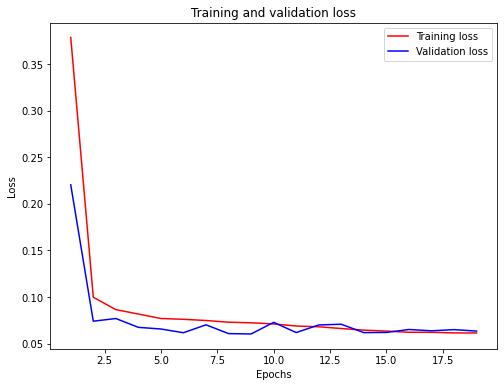

In [20]:
from matplotlib.pyplot import plot,savefig
loss = history.history['loss']
val_loss = history.history['val_loss']
epoch = range(1,len(loss)+1)
plt.figure(figsize=(8, 6))

#plt.semilogy(epoch,loss, color="red",label='Training loss')
#plt.semilogy(epoch, val_loss,color="blue", label='Validation loss')

plt.plot(epoch,loss, color="red",label='Training loss')
plt.plot(epoch, val_loss,color="blue", label='Validation loss')


plt.legend()
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [21]:
loss=np.array(loss)
val_loss=np.array(val_loss)
epoch=np.array(epoch)

loss=loss.reshape(loss.shape[0],1)
val_loss=val_loss.reshape(val_loss.shape[0],1)
epoch=epoch.reshape(epoch.shape[0],1)

loss_zong=np.concatenate((epoch,loss,val_loss),axis=1)


print(epoch.shape)
print(val_loss.shape)
print(loss.shape)
print(loss_zong.shape)

data_loss = pd.DataFrame(loss_zong) #将数组转换为dataframe结构
data_loss.columns=['epoch','loss','val_loss']
writer_loss = pd.ExcelWriter(r'\PGAloss3.xls')   # 写入Excel文件

data_loss.to_excel(writer_loss,float_format='%.5f',index=False)   ## ‘page_1’是写入excel的sheet名
writer_loss.save()
writer_loss.close()

(19, 1)
(19, 1)
(19, 1)
(19, 3)


训练标准差STD= 0.24734831636858354
训练误差均值MEAN= -0.003747550090126821
训练平均绝对误差MAE= 0.18979106271521748
训练RMSE= 0.2473767041215702
训练MAPE= 52.223370058188934
训练r2 score: 0.7125810748251404


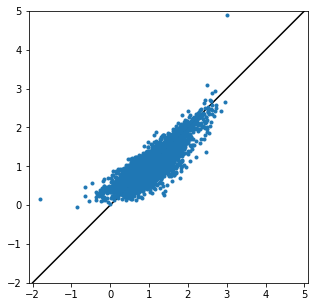

In [21]:
from sklearn import metrics
from sklearn.metrics import r2_score
print("训练标准差STD=",np.std(pred_train_all-train_y.ravel()))
print("训练误差均值MEAN=",np.mean(pred_train_all-train_y.ravel()))
print("训练平均绝对误差MAE=",metrics.mean_absolute_error(pred_train_all, train_y.ravel()))
print("训练RMSE=",metrics.mean_squared_error(pred_train_all, train_y.ravel())**0.5)
print("训练MAPE=",np.mean(np.abs((train_y.ravel() - pred_train_all) / train_y.ravel())) * 100)
print("训练r2 score:", r2_score(train_y.ravel(), pred_train_all))


plt.figure(figsize=(5, 5))
plt.axis('equal')

x3 = np.arange(-2, 5, 0.01)
y3=x3
plt.plot(x3, y3, "black")
plt.plot(train_y.ravel(),pred_train_all,'.')
plt.xlim(-2, 5)
plt.ylim(-2, 5)
plt.show()

In [23]:
#########################保存训练结果####################################
pred_train_all=pred_train_all.reshape(pred_train_all.shape[0],1)

#y_score_tr=y_score_tr.reshape(y_score_tr.shape[0],1)
print(pred_train_all.shape)
print(train_y.shape)

tr_result=np.concatenate((train_y,pred_train_all),axis=1)

print(tr_result.shape)

data_tr = pd.DataFrame(tr_result) #将数组转换为dataframe结构
data_tr.columns=['实际PGA','预测PGA']
writer_tr = pd.ExcelWriter(r'\PGAtrain3.xls')   # 写入Excel文件

data_tr.to_excel(writer_tr,float_format='%.5f',index=False)   ## ‘page_1’是写入excel的sheet名
writer_tr.save()
writer_tr.close()
#########################保存训练结果####################################

(5676, 1)
(5676, 1)
(5676, 2)


测试标准差STD= 0.26107222214909437
测试误差均值MEAN= 0.011147087924821301
测试平均绝对误差MAE= 0.20545024890363794
测试RMSE= 0.2613100892561743
测试MAPE= 41.51281574935874
测试r2 score: 0.6882144246277078


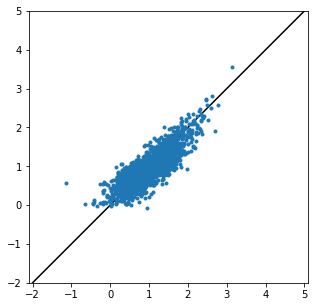

In [22]:
print("测试标准差STD=",np.std(pred_test_all-test_y.ravel()))
print("测试误差均值MEAN=",np.mean(pred_test_all-test_y.ravel()))
print("测试平均绝对误差MAE=",metrics.mean_absolute_error(pred_test_all, test_y.ravel()))
print("测试RMSE=",metrics.mean_squared_error(pred_test_all, test_y.ravel())**0.5)
print("测试MAPE=",np.mean(np.abs((test_y.ravel() - pred_test_all) / test_y.ravel())) * 100)
print("测试r2 score:", r2_score(test_y.ravel(), pred_test_all))


plt.figure(figsize=(5, 5))
plt.axis('equal')

x3 = np.arange(-2, 5, 0.01)
y3=x3
plt.plot(x3, y3, "black")
plt.plot(test_y.ravel(),pred_test_all,'.')
plt.xlim(-2, 5)
plt.ylim(-2, 5)
plt.show()   

In [25]:
#########################保存测试结果####################################
pred_test_all=pred_test_all.reshape(pred_test_all.shape[0],1)

print(pred_test_all.shape)
print(test_y.shape)

te_result=np.concatenate((test_y,pred_test_all),axis=1)

print(te_result.shape)

data_te = pd.DataFrame(te_result) #将数组转换为dataframe结构
data_te.columns=['实际PGA','预测PGA']
writer_te = pd.ExcelWriter(r'\PGAtest3.xls')   # 写入Excel文件

data_te.to_excel(writer_te,float_format='%.5f',index=False)   ## ‘page_1’是写入excel的sheet名
writer_te.save()
writer_te.close()
#########################保存测试结果####################################

(2392, 1)
(2392, 1)
(2392, 2)


In [23]:
#震例
import scipy.io as scio
import pandas as pd

#input
feature1z = r'\积石山震例\ACC_EW.mat'
data1z = scio.loadmat(feature1z)
AAz=data1z['ACC_EW']
Az=AAz[:,0:300]

feature2z = r'\积石山震例\ACC_NS.mat'
data2z = scio.loadmat(feature2z)
BBz=data2z['ACC_NS']
Bz=BBz[:,0:300]

feature3z = r'\积石山震例\ACC_UD.mat'
data3z = scio.loadmat(feature3z)
CCz=data3z['ACC_UD']
Cz=CCz[:,0:300]

feature4z = r'\积石山震例\DIS_EW.mat'
data4z = scio.loadmat(feature4z)
DDz=data4z['DIS_EW']
Dz=DDz[:,0:300]

feature5z = r'\积石山震例\DIS_NS.mat'
data5z = scio.loadmat(feature5z)
EEz=data5z['DIS_NS']
Ez=EEz[:,0:300]

feature6z = r'\积石山震例\DIS_UD.mat'
data6z = scio.loadmat(feature6z)
FFz=data6z['DIS_UD']
Fz=FFz[:,0:300]

feature7z = r'\积石山震例\VEL_EW.mat'
data7z = scio.loadmat(feature7z)
GGz=data7z['VEL_EW']
Gz=GGz[:,0:300]

feature8z = r'\积石山震例\VEL_NS.mat'
data8z = scio.loadmat(feature8z)
HHz=data8z['VEL_NS']
Hz=HHz[:,0:300]

feature9z = r'\积石山震例\VEL_UD.mat'
data9z = scio.loadmat(feature9z)
IIz=data9z['VEL_UD']
Iz=IIz[:,0:300]


labelz = pd.read_csv(open(r'\积石山震例\震例PGA参数3s.csv',encoding='UTF-8'))


In [24]:
raw_data1z=np.hstack((Az,Bz))
raw_data2z=np.hstack((raw_data1z,Cz))
raw_data3z=np.hstack((raw_data2z,Dz))
raw_data4z=np.hstack((raw_data3z,Ez))
raw_data5z=np.hstack((raw_data4z,Fz))
raw_data6z=np.hstack((raw_data5z,Gz))
raw_data7z=np.hstack((raw_data6z,Hz))
x_dataz=np.hstack((raw_data7z,Iz))

y_dataz=labelz.iloc[:,[0,1,2,3,4,5,6,7,8,9]].values  #知识嵌入
#y_data=label.iloc[:,[12]].values    #导入数据  iloc通过行号获取行数据
print(y_dataz[0])
print(y_dataz.shape)

[-0.83242318 -0.3391172   1.14167608 -0.54745731  1.30126289 -0.5319254
  3.30376988  1.90669845  1.67392068  1.81095491]
(919, 10)


In [25]:
zhenli_y=y_dataz[:,[9]]
zhenli_physics=y_dataz[:,[0,1,2,3,4,5,6,7,8]]
print(zhenli_y.shape)
print(zhenli_y[0])

print(zhenli_physics.shape)
print(zhenli_physics[0])


(919, 1)
[1.81095491]
(919, 9)
[-0.83242318 -0.3391172   1.14167608 -0.54745731  1.30126289 -0.5319254
  3.30376988  1.90669845  1.67392068]


In [26]:
zhenli_x=[]
for i in range(len(x_dataz)):
    zhenli_x.append(np.array(x_dataz[i].reshape(9,1,300)).T)

In [27]:
zhenli_x=np.array(zhenli_x)

In [28]:
zhenli_x = np.reshape(zhenli_x, (zhenli_x.shape[0], 300, 9))

In [29]:
pred_zhenli_all = model.predict([zhenli_x,zhenli_physics]).ravel()  ##ravel() 转换成1列

震例标准差STD= 0.29569422352577596
震例误差均值MEAN= -0.19340167927250643
震例平均绝对误差MAE= 0.2938051603206099
震例RMSE= 0.3533260298533594
震例MAPE= 38.613862624483716
震例r2 score: 0.7119391322528095


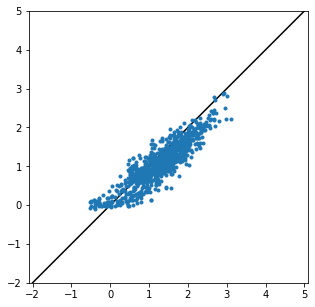

In [30]:
print("震例标准差STD=",np.std(pred_zhenli_all-zhenli_y.ravel()))
print("震例误差均值MEAN=",np.mean(pred_zhenli_all-zhenli_y.ravel()))
print("震例平均绝对误差MAE=",metrics.mean_absolute_error(pred_zhenli_all, zhenli_y.ravel()))
print("震例RMSE=",metrics.mean_squared_error(pred_zhenli_all, zhenli_y.ravel())**0.5)
print("震例MAPE=",np.mean(np.abs((zhenli_y.ravel() - pred_zhenli_all) / zhenli_y.ravel())) * 100)
print("震例r2 score:", r2_score(zhenli_y.ravel(), pred_zhenli_all))


plt.figure(figsize=(5, 5))
plt.axis('equal')

x3 = np.arange(-2, 5, 0.01)
y3=x3
plt.plot(x3, y3, "black")
plt.plot(zhenli_y.ravel(),pred_zhenli_all,'.')
plt.xlim(-2, 5)
plt.ylim(-2, 5)
plt.show()  

In [31]:
#########################保存震例结果####################################
pred_zhenli_all=pred_zhenli_all.reshape(pred_zhenli_all.shape[0],1)

print(pred_zhenli_all.shape)
print(zhenli_y.shape)

tz_result=np.concatenate((zhenli_y,pred_zhenli_all),axis=1)

print(tz_result.shape)

data_tz = pd.DataFrame(tz_result) #将数组转换为dataframe结构
data_tz.columns=['实际PGA','预测PGA']
writer_tz = pd.ExcelWriter(r'\积石山震例\PGAzhenli3.xls')   # 写入Excel文件

data_tz.to_excel(writer_tz,float_format='%.5f',index=False)   ## ‘page_1’是写入excel的sheet名
writer_tz.save()
writer_tz.close()
#########################保存震例结果####################################

(919, 1)
(919, 1)
(919, 2)
